In [ ]:
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.48
    Uninstalling yfinance-0.2.48:
      Successfully uninstalled yfinance-0.2.48


In [2]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [3]:
nvidia = yf.Ticker("NVDA")
history = nvidia.history(period="1y")
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-13 00:00:00-05:00,48.305381,49.101142,48.084447,48.605289,384136000,0.0,0.0
2023-11-14 00:00:00-05:00,49.664975,49.818927,49.025169,49.640980,416954000,0.0,0.0
2023-11-15 00:00:00-05:00,49.919899,49.944889,48.185423,48.873215,475497000,0.0,0.0
2023-11-16 00:00:00-05:00,48.664282,49.510027,48.315388,49.465038,339756000,0.0,0.0
2023-11-17 00:00:00-05:00,49.509022,49.701965,48.992180,49.283092,325205000,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-07 00:00:00-05:00,146.389999,148.929993,146.169998,148.880005,207323300,0.0,0.0
2024-11-08 00:00:00-05:00,148.770004,149.770004,146.259995,147.630005,175665800,0.0,0.0
2024-11-11 00:00:00-05:00,148.679993,148.850006,143.570007,145.259995,182325600,0.0,0.0


Daily closing prices for 1 year. Keep in mind that the Daye is the index.

In [4]:
close_nvidia = history['Close']
close_nvidia

,Close
Date,
2023-11-13 00:00:00-05:00,48.605289
2023-11-14 00:00:00-05:00,49.640980
2023-11-15 00:00:00-05:00,48.873215
2023-11-16 00:00:00-05:00,49.465038
2023-11-17 00:00:00-05:00,49.283092
...,...
2024-11-07 00:00:00-05:00,148.880005
2024-11-08 00:00:00-05:00,147.630005
2024-11-11 00:00:00-05:00,145.259995


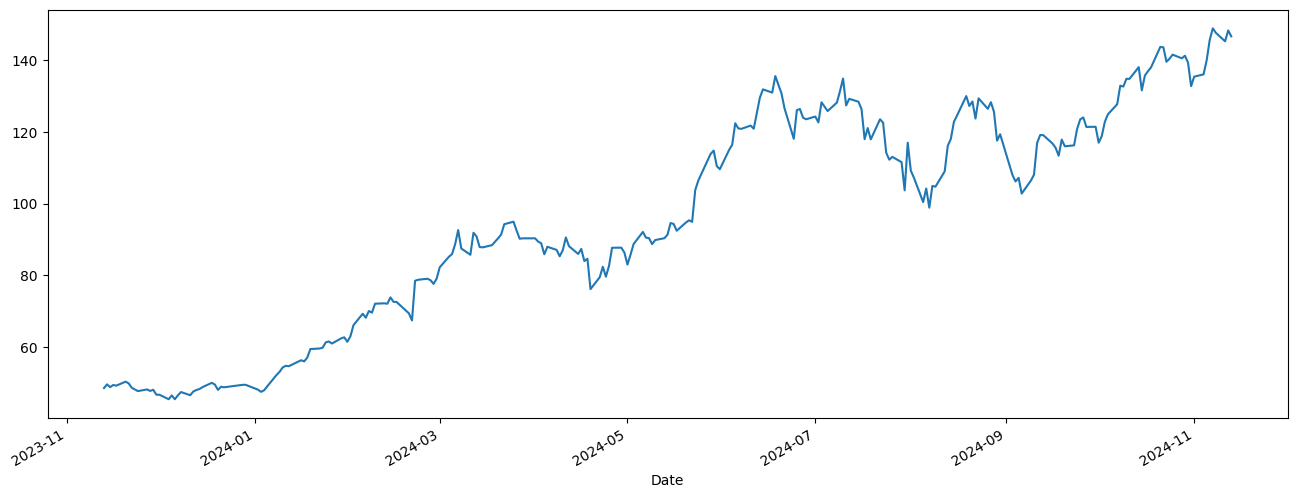

In [5]:
close_nvidia.plot(figsize=(16,6))
plt.show()


We can observe the increasing trend. Meaning the data is definitely non-stationary. Let's decompose it and bring it to the stationary state.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
df_nvidia = pd.DataFrame(close_nvidia)

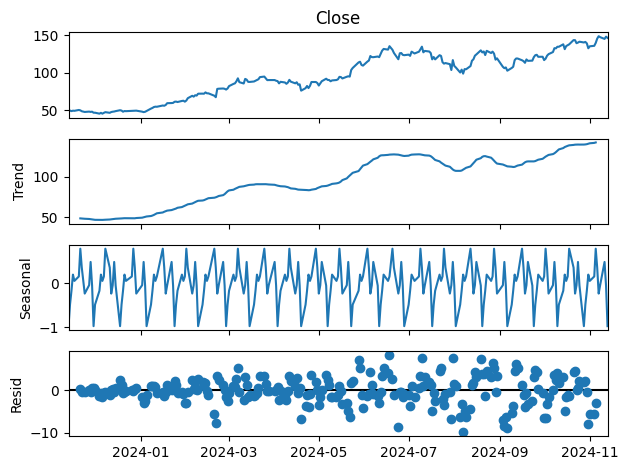

In [8]:
decomposition = seasonal_decompose(df_nvidia['Close'], model='additive', period=12)
decomposition.plot()
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df_nvidia)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.7610826225462998
p-value: 0.8302873894980243


p>>0.05, meaning the data is not stationary(the null hypothesis for the ADF test)

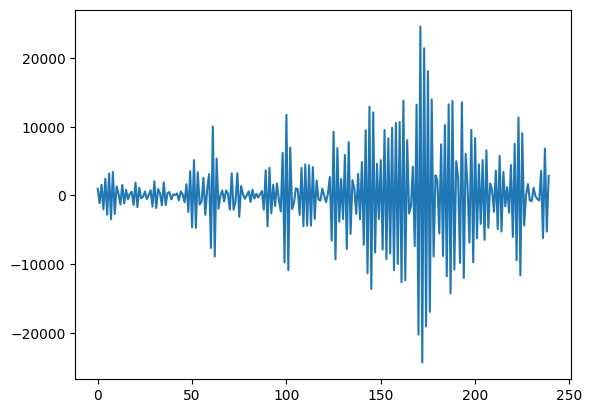

In [10]:
# from pmdarima.arima.utils import ndiffs
diff_nvidia = np.diff(np.diff(df_nvidia['Close'], n = 12), n=1)
plt.plot(diff_nvidia)

Most of the stocks display a similar pattern differencing; drasticly large wavelength in the recent times.

Let's repeat the ADF test

In [11]:
ADF_result = adfuller(diff_nvidia)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -19.978343402167333
p-value: 0.0


Now we have p < 0.05, which rejects the null hypothesis and states that the data is now stationary.

Checking for random walk

---



# Original Data ACF

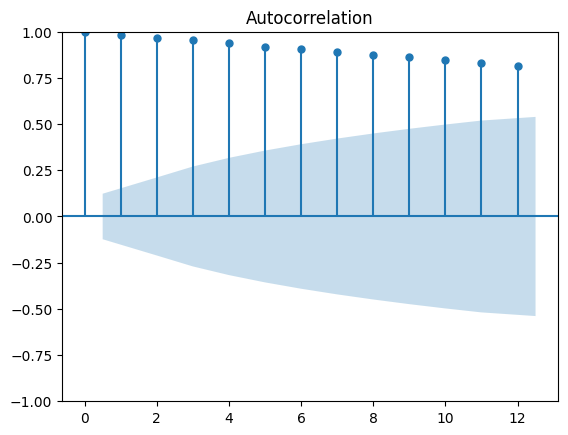

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_nvidia, lags=12);

# Differenced data's ACF

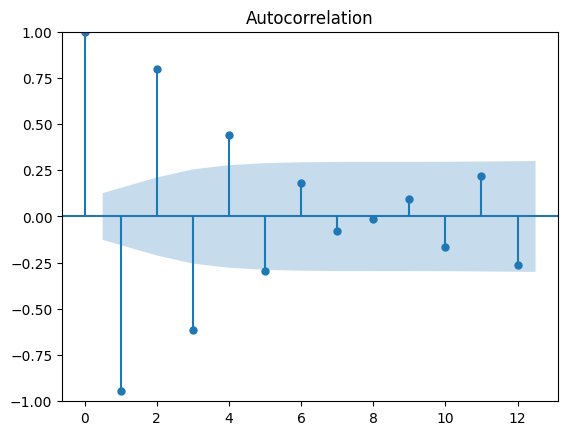

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff_nvidia, lags=12);

Since there is no whote noise after the lag0, nor there is a distinction between any q significant and non-significant lags, we can't use random walk or moving average (MA(q))  let's proceed with a PACF graph to see if we can use an AR(p).

# Differenced Data's PACF



Checking differenced data sizes. Note that first order differencing is 1 observation less than the original, but the seasonal is 12 observations less, meaning the resulting both first-order and seasonal differencing will have in total of 13 obs. less than the original data.



In [14]:

print('Original data:',df_nvidia.shape)
print('First-order differenced:',np.diff(df_nvidia['Close'], n = 1).shape)
print('Seasonally differenced:',np.diff(df_nvidia['Close'], n = 12).shape)
print('My differenced data:', diff_nvidia.shape)

Original data: (253, 1)
First-order differenced: (252,)
Seasonally differenced: (241,)
My differenced data: (240,)


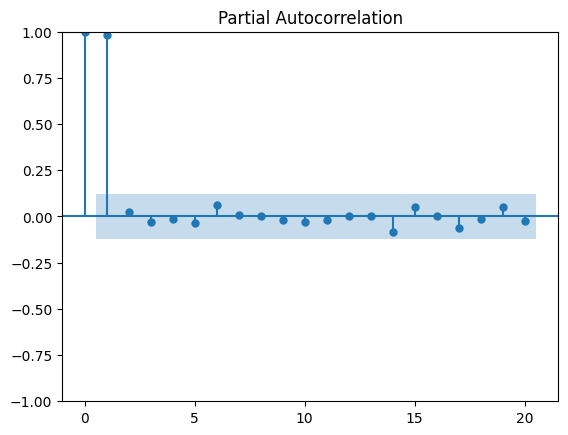

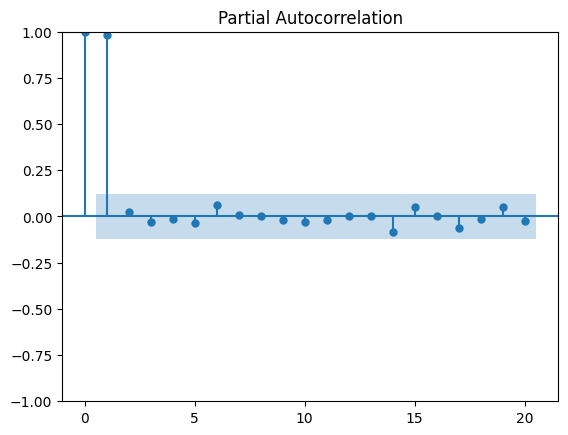

In [15]:
plot_pacf(df_nvidia, lags=20)

In the pACF the lag1 is the only significant (except the lag0 which is compared to itself), p=1 AR(p)

**NOTE: Visible sinusoidal pattern**


# Running the Naive Forecast

In [16]:
train_nvidia = df_nvidia[:-5]
train_nvidia.head()

,Close
Date,
2023-11-13 00:00:00-05:00,48.605289
2023-11-14 00:00:00-05:00,49.640980
2023-11-15 00:00:00-05:00,48.873215
2023-11-16 00:00:00-05:00,49.465038
2023-11-17 00:00:00-05:00,49.283092


In [30]:
test_nvidia = df_nvidia[-5:]
test_nvidia
# t = test_nvidia
# new_row = pd.DataFrame({'Close': np.nan}, index=[pd.Timestamp('2024-11-13 00:00:00', tz='America/New_York')])

# test_nvidia = pd.concat([test_nvidia, new_row])

# test_nvidia = test_nvidia.sort_index()
# test_nvidia

,Close
Date,
2024-11-07 00:00:00-05:00,148.880005
2024-11-08 00:00:00-05:00,147.630005
2024-11-11 00:00:00-05:00,145.259995
2024-11-12 00:00:00-05:00,148.289993
2024-11-13 00:00:00-05:00,146.649994


In [57]:
nvidia_test_forecast = test_nvidia.shift(periods = 1)
print(train_nvidia[-5:])
print(test_nvidia[-5:])
print(nvidia_test_forecast[-5:])



                                Close
Date                                 
2024-10-31 00:00:00-04:00  132.759995
2024-11-01 00:00:00-04:00  135.399994
2024-11-04 00:00:00-05:00  136.050003
2024-11-05 00:00:00-05:00  139.910004
2024-11-06 00:00:00-05:00  145.610001
                                Close  pred_mean   pred_last
Date                                                        
2024-11-07 00:00:00-05:00  148.880005  95.119316  145.610001
2024-11-08 00:00:00-05:00  147.630005  95.119316  145.610001
2024-11-11 00:00:00-05:00  145.259995  95.119316  145.610001
2024-11-12 00:00:00-05:00  148.289993  95.119316  145.610001
2024-11-13 00:00:00-05:00  146.649994  95.119316  145.610001
                                Close
Date                                 
2024-10-31 00:00:00-04:00  139.339996
2024-11-01 00:00:00-04:00  132.759995
2024-11-04 00:00:00-05:00  135.399994
2024-11-05 00:00:00-05:00  136.050003
2024-11-06 00:00:00-05:00  139.910004


Forecast for the 2024-11-07 with Naive method will be 146.649994

In [50]:
from sklearn.metrics import mean_squared_error
mse_naive_nvidia = mean_squared_error(test_nvidia['Close'][-4:],nvidia_test_forecast[-4:])
print(test_nvidia[-4:])
print(nvidia_test_forecast[-4:])
print(mse_naive_nvidia)

                                Close  pred_mean   pred_last
Date                                                        
2024-11-08 00:00:00-05:00  147.630005  95.119316  145.610001
2024-11-11 00:00:00-05:00  145.259995  95.119316  145.610001
2024-11-12 00:00:00-05:00  148.289993  95.119316  145.610001
2024-11-13 00:00:00-05:00  146.649994  95.119316  145.610001
                                Close
Date                                 
2024-11-08 00:00:00-05:00  148.880005
2024-11-11 00:00:00-05:00  147.630005
2024-11-12 00:00:00-05:00  145.259995
2024-11-13 00:00:00-05:00  148.289993
4.762484945706092


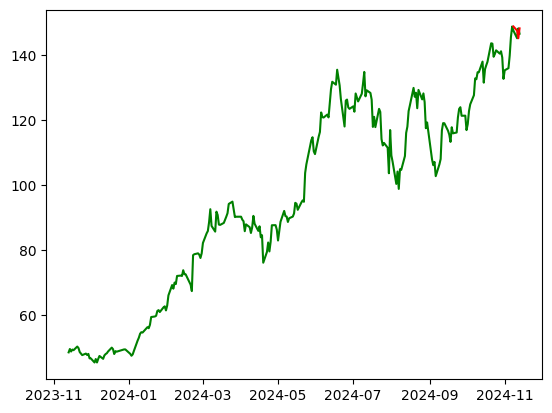

In [24]:
fig, ax = plt.subplots()
ax.plot(df_nvidia, 'g-', label='Close')
ax.plot(nvidia_test_forecast, 'r-', label = 'Naive')
plt.show()

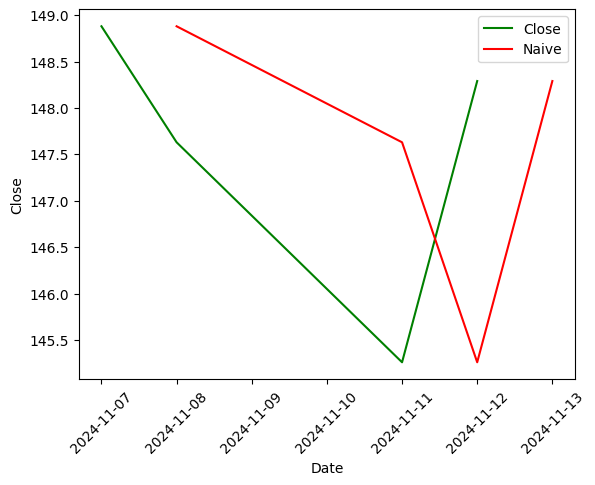

In [26]:
fig, ax = plt.subplots()
ax.plot(test_nvidia[:-1], 'g-', label='Close')
ax.plot(nvidia_test_forecast, 'r-', label = 'Naive')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [39]:
# mean_nvidia = np.mean(df_nvidia)
nvidia_mean = np.mean(train_nvidia['Close'])
test_nvidia.loc[:, 'pred_mean'] = nvidia_mean
last_value = float(train_nvidia.iloc[-1].values)
print(last_value)
test_nvidia.loc[:, 'pred_last'] = last_value
print(nvidia_mean)


145.61000061035156
95.11931639332926


<ipython-input-39-df960aa32b1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nvidia.loc[:, 'pred_mean'] = nvidia_mean
<ipython-input-39-df960aa32b1c>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_value = float(train_nvidia.iloc[-1].values)
<ipython-input-39-df960aa32b1c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

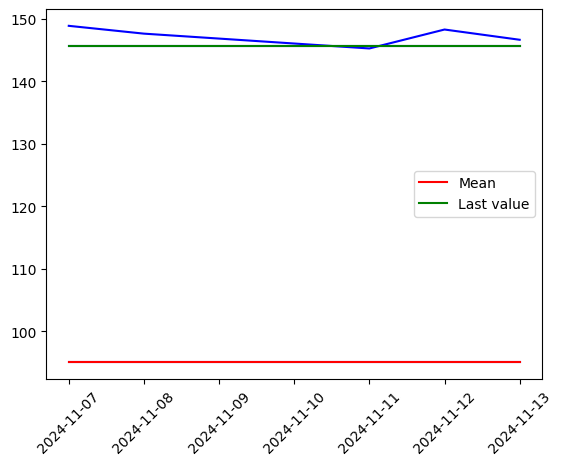

In [28]:
fig, ax = plt.subplots()
ax.plot(test_nvidia, 'b-')
ax.plot(test_nvidia['pred_mean'], 'r', label='Mean')
ax.plot(test_nvidia['pred_last'], 'g', label='Last value')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [29]:
print(test_nvidia)

                                Close  pred_mean   pred_last
Date                                                        
2024-11-07 00:00:00-05:00  148.880005  95.119316  145.610001
2024-11-08 00:00:00-05:00  147.630005  95.119316  145.610001
2024-11-11 00:00:00-05:00  145.259995  95.119316  145.610001
2024-11-12 00:00:00-05:00  148.289993  95.119316  145.610001
2024-11-13 00:00:00-05:00  146.649994  95.119316  145.610001


In [51]:
print(test_nvidia)
print(test_nvidia['pred_mean'])
print(test_nvidia['pred_last'])
mse_mean = mean_squared_error(test_nvidia['Close'], test_nvidia['pred_mean'])
mse_last = mean_squared_error(test_nvidia['Close'], test_nvidia['pred_last'])
print("Mean forecast:", mse_mean)
print("Last value forecast:", mse_last)
print('Naive forecast:', mse_naive_nvidia)

                                Close  pred_mean   pred_last
Date                                                        
2024-11-07 00:00:00-05:00  148.880005  95.119316  145.610001
2024-11-08 00:00:00-05:00  147.630005  95.119316  145.610001
2024-11-11 00:00:00-05:00  145.259995  95.119316  145.610001
2024-11-12 00:00:00-05:00  148.289993  95.119316  145.610001
2024-11-13 00:00:00-05:00  146.649994  95.119316  145.610001
Date
2024-11-07 00:00:00-05:00    95.119316
2024-11-08 00:00:00-05:00    95.119316
2024-11-11 00:00:00-05:00    95.119316
2024-11-12 00:00:00-05:00    95.119316
2024-11-13 00:00:00-05:00    95.119316
Name: pred_mean, dtype: float64
Date
2024-11-07 00:00:00-05:00    145.610001
2024-11-08 00:00:00-05:00    145.610001
2024-11-11 00:00:00-05:00    145.610001
2024-11-12 00:00:00-05:00    145.610001
2024-11-13 00:00:00-05:00    145.610001
Name: pred_last, dtype: float64
Mean forecast: 2728.8406478716365
Last value forecast: 4.631959250522778
Naive forecast: 4.7624849457060

Last value is the closer to the original values, hence is more preferable than both the mean and naive forecasts.

In [ ]:
# predictions['naive'] = mse_naive_nvidia
# predictions['last_value'] = last_error


# Holt's Smoothing Forecasts for the test dataset

In [31]:
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
holt_trend = Holt(test_nvidia['Close']).fit(smoothing_level=0.8, smoothing_trend=0.2)
holt_trend_forecast = holt_trend.forecast(steps=len(test_nvidia)-1)
print("Holt's Double Exponential Smoothing (Trend Only) Forecast:")
print(holt_trend_forecast)

Holt's Double Exponential Smoothing (Trend Only) Forecast:
2024-11-14 00:00:00-05:00    146.049251
2024-11-15 00:00:00-05:00    145.403238
2024-11-18 00:00:00-05:00    144.757225
2024-11-19 00:00:00-05:00    144.111213
Freq: B, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [32]:
mean_squared_error(test_nvidia[:-1], holt_trend_forecast)

7.67166055366399

In [33]:
holt_seasonal = ExponentialSmoothing(
    train_nvidia['Close'],
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()
holt_seasonal_forecast = holt_seasonal.forecast(steps=len(test_nvidia)-1)
print(holt_seasonal_forecast)

248    144.917998
249    145.409460
250    145.448776
251    146.178236
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
mse_holt_trend = mean_squared_error(test_nvidia['Close'][:-1], holt_trend_forecast)
mse_holt_seasonal = mean_squared_error(test_nvidia['Close'][:-1], holt_seasonal_forecast)
print("Holt's(Trend Only) MSE:", mse_holt_trend)
print("Holt's (Trend + Seasonality) MSE:", mse_holt_seasonal)

Holt's(Trend Only) MSE: 7.67166055366399
Holt's (Trend + Seasonality) MSE: 6.280869094435261


From the results above we see that the Holt's Seasonality works better than the regular trend smoothing method.